# Система прогнозирования отказа от брони клиента

Заказчик этого исследования — сеть отелей «Как в гостях». Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента. Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

- id — номер записи;
- is_canceled — отмена заказа;
- lead_time — количество дней между датой бронирования и датой прибытия;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- adults — количество взрослых постояльцев;
- children — количество детей от 3 до 14 лет;
- babies — количество младенцев;
- meal — опции заказа:
  - SC — нет дополнительных опций;
  - BB — включён завтрак;
  - HB — включён завтрак и обед;
  - FB — включён завтрак, обед и ужин.
- country — гражданство постояльца;
- distribution_channel — канал дистрибуции заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- previous_cancellations — количество отменённых заказов у клиента;
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- reserved_room_type — тип забронированной комнаты;
- booking_changes — количество изменений параметров заказа;
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- customer_type — тип заказчика:
  - Contract — договор с юридическим лицом;
  - Group — групповой заезд;
  - Transient — не связано с договором или групповым заездом;
  - Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- required_car_parking_spaces — необходимость места для автомобиля;
- total_of_special_requests — количество специальных отметок.
- total_nights — общее количество ночей;

### Шаг 1. Откроем файлы с данными

In [1]:
#!pip install scikit-learn==1.1.3

In [2]:
#!pip install imblearn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

In [4]:
pd.set_option('max_columns', None)

In [5]:
try:
    data_train = pd.read_csv('C:/Users/Student/Desktop/hotel_train.csv')
    data_test = pd.read_csv('C:/Users/Student/Desktop/hotel_test.csv')
except:
    data_train = pd.read_csv('/datasets/hotel_train.csv')
    data_test = pd.read_csv('/datasets/hotel_test.csv')

### Шаг 2. Предобработка и исследовательский анализ данных

#### Исследование данных

In [6]:
def func_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print(('Количество дубликатов по всему датасету: {0}').format(data.duplicated().sum()))
    print(('Количество дубликатов в столбце id: {0}').format(data['id'].duplicated().sum()))
    return

In [7]:
def func_hist(data):
    for column in data.drop(['id', 'is_canceled', 'lead_time', 'country'], axis=1).columns:
        data.pivot_table('id', column, 'is_canceled', 'count').plot(kind='bar')

Изучим датасеты трейна и теста: посмотрим первые пять строк датасетов, информацию о датасетах, описание данных датасетов и наличие дубликатов.

In [8]:
func_info(data_train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Количество дубликатов по всему датасету: 0
Количество дубликатов в столбце id: 0


In [9]:
func_info(data_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Количество дубликатов по всему датасету: 0
Количество дубликатов в столбце id: 0


В данных не было найдено пропусков и дубликатов, но встречаются столбцы с аномальными значениями, которые будут исследованы дальше.

#### Анализ данных

Построим столбчатые диаграммы для трейна и теста с учетом отмены брони и без отмены брони.

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


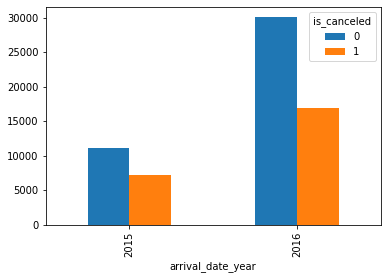

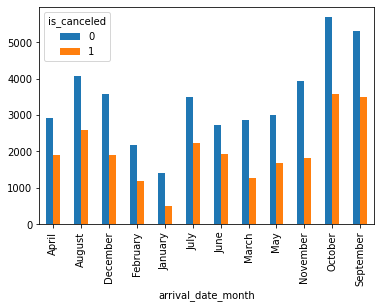

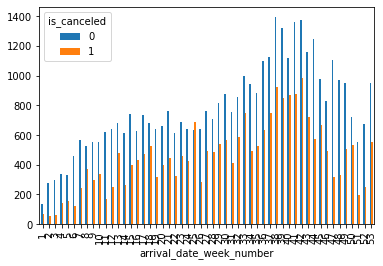

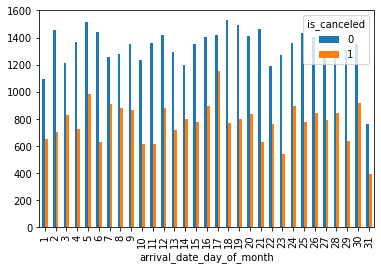

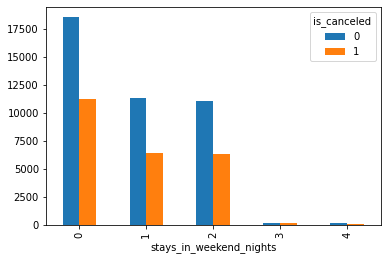

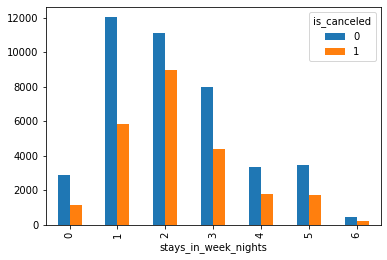

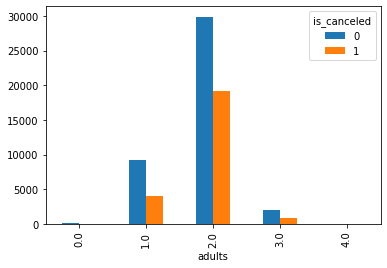

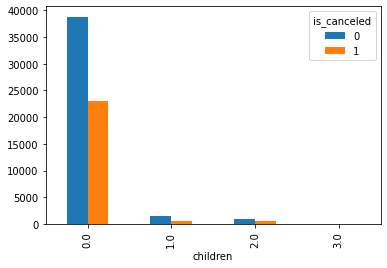

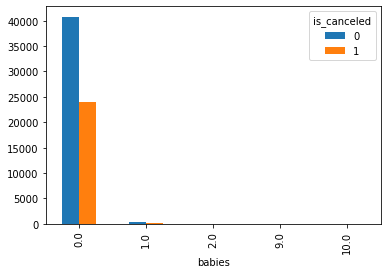

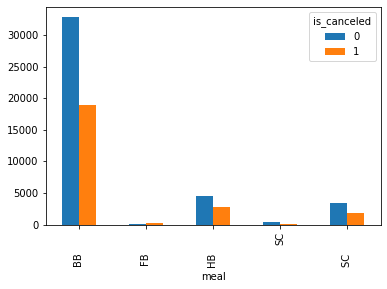

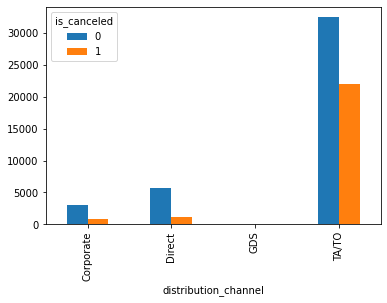

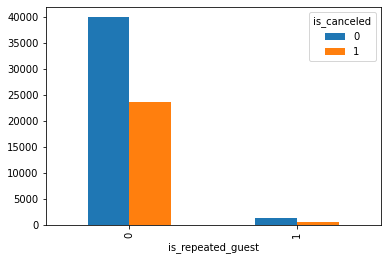

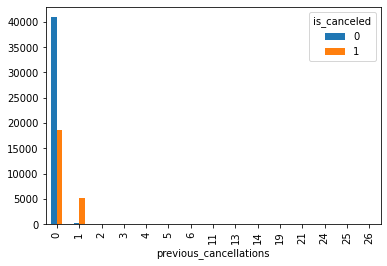

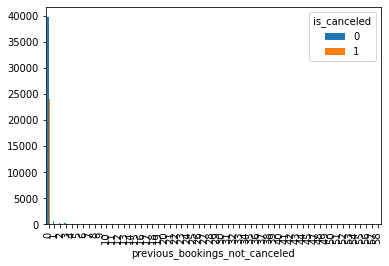

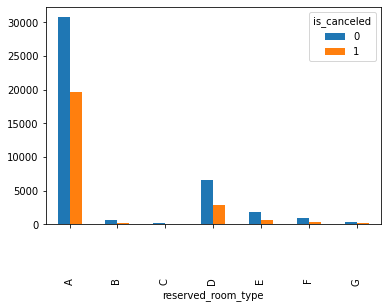

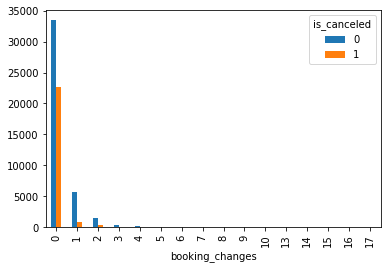

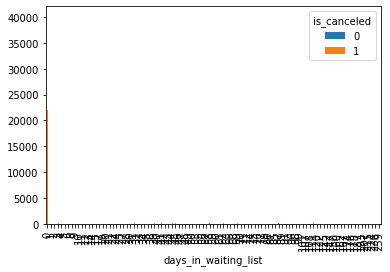

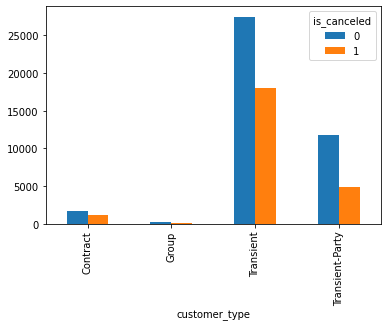

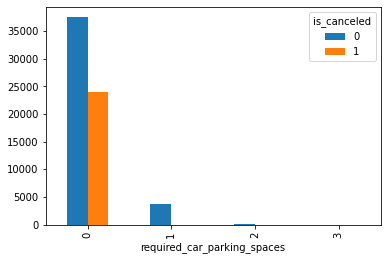

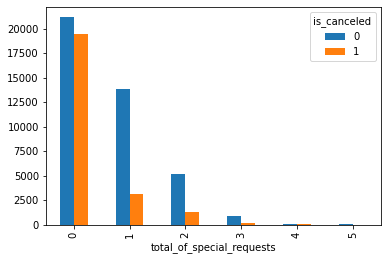

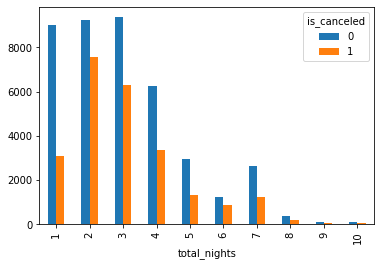

In [10]:
func_hist(data_train)

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


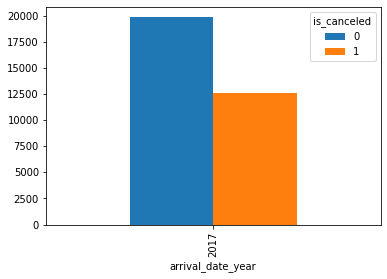

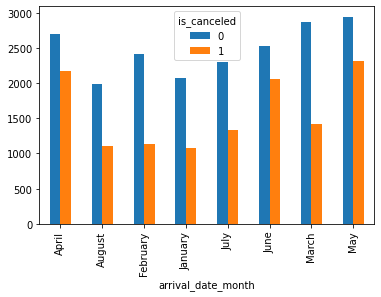

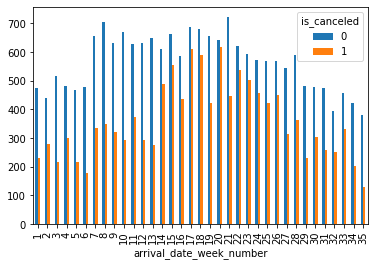

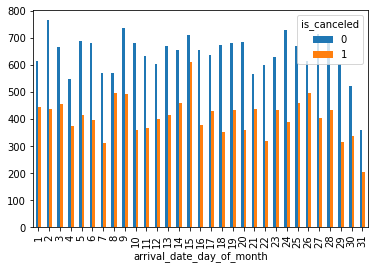

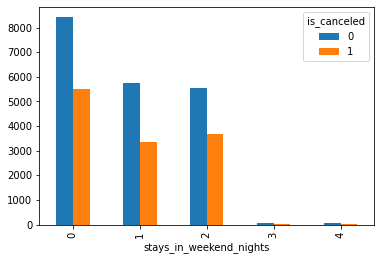

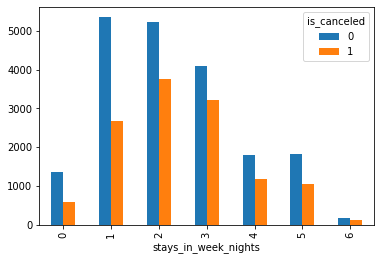

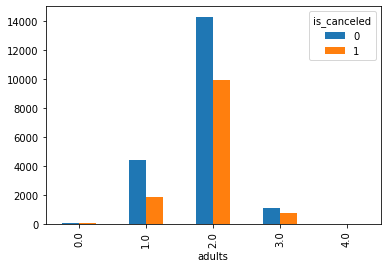

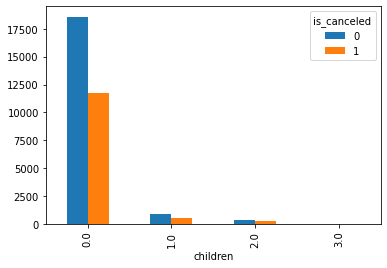

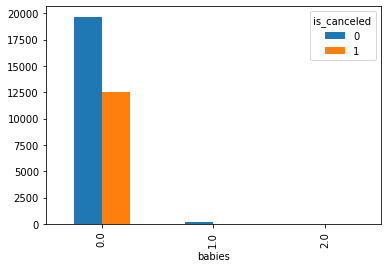

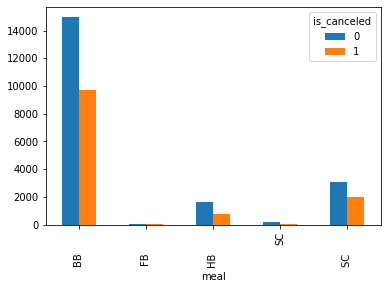

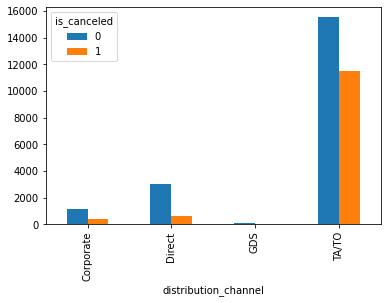

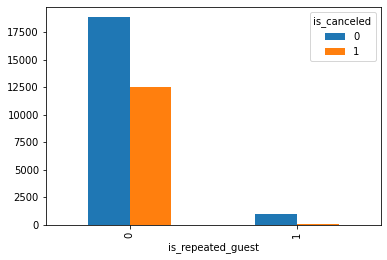

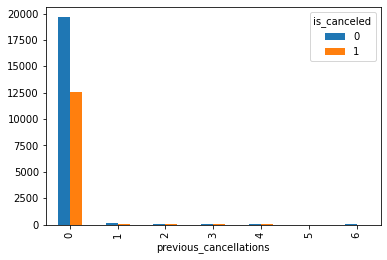

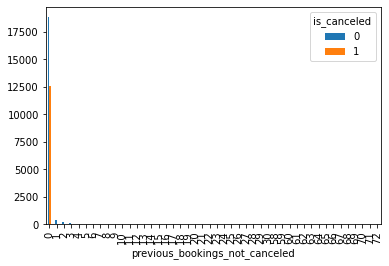

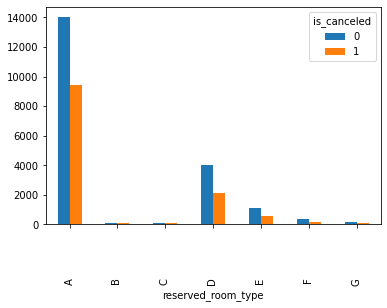

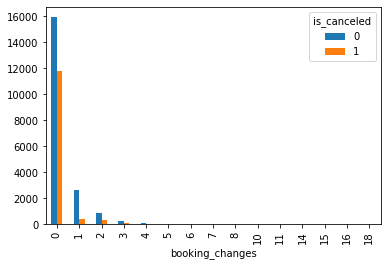

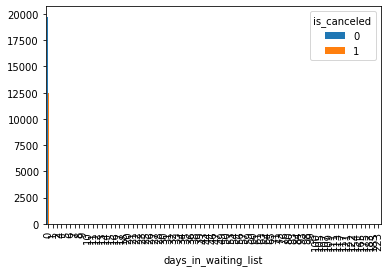

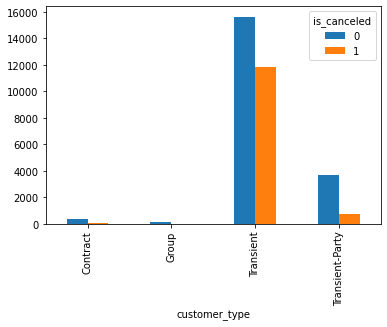

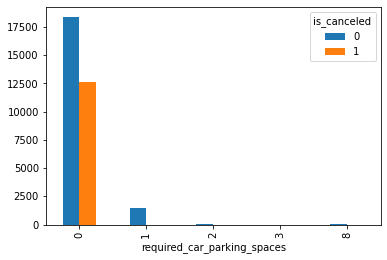

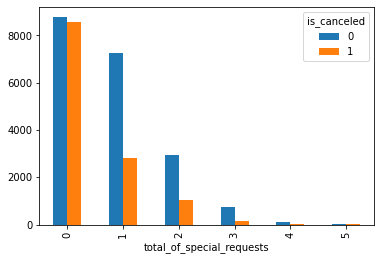

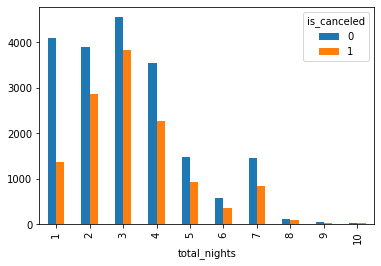

In [11]:
func_hist(data_test)

Построим графики частоты встречающихся значений количества дней между датой бронирования и датой прибытия для трейна и теста с учетом отмены брони и без отмены брони.

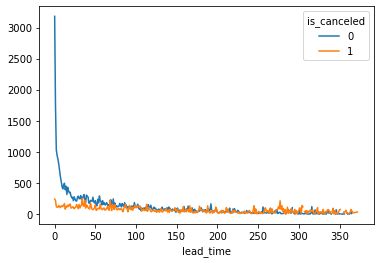

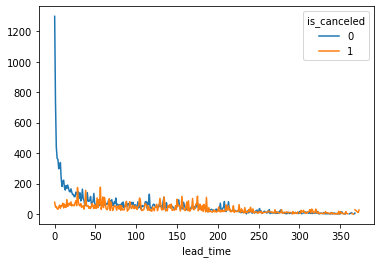

In [12]:
data_train.pivot_table('id', 'lead_time', 'is_canceled', 'count').plot();
data_test.pivot_table('id', 'lead_time', 'is_canceled', 'count').plot();

Чаще всего отказываются от бронирования осенью, реже всего зимой. 

К концу месяца отказ от брони реже, в середине месяца выше.

Чаще всего отказываются те, кто не остается на выходные, а остается на два дня посреди недели.

Чаще всего откзаываются от бронирования двое взрослых, которые не имеют детей любого возраста.

Чаще от бронирования отказываются те, у кого включен завтрак, а тип забронированной комнаты - A.

Чаще отказываются те, у кого канал дистрибуции TA/TO, а тип заказа не связан ни с договором, ни с групповым заездом.

Чаще всего отказываются те, кто бронирует номер впервые.

Чаще всего отказываются те, кто не отменял заказ то этого.

Чаще всего отказываются при нулевом изменении параметров заказа и нулевым количеством специальных отметок.

Чаще всего отказываются при подтверждении заказа в день его оформления.

Чаще всего отказываются тех, кому не требуется парковочное место.

Отказываются от бронирования вне зависимости от дней между датой бронирования и датой прибытия. 

#### Поиск и удаление аномальных значений

Исследуем аномальные значения в стоблцах 'adults', 'babies', 'previous_cancellations', 'days_in_waiting_list'. 

In [13]:
column_anomalii = ['adults', 'babies', 'previous_cancellations']
def anomalii_func(data, column_anomalii=column_anomalii):
    for column in column_anomalii:
        display(data.groupby(column)[column].count())

In [14]:
anomalii_func(data_train)

adults
0.0      166
1.0    13212
2.0    48980
3.0     2858
4.0       13
Name: adults, dtype: int64

babies
0.0     64777
1.0       447
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

previous_cancellations
0     59591
1      5367
2        54
3        51
4         5
5        13
6         7
11       35
13       12
14       11
19       17
21        1
24       28
25       19
26       18
Name: previous_cancellations, dtype: int64

In [15]:
anomalii_func(data_test)

adults
0.0       69
1.0     6280
2.0    24237
3.0     1817
4.0        9
Name: adults, dtype: int64

babies
0.0    32237
1.0      171
2.0        4
Name: babies, dtype: int64

previous_cancellations
0    32186
1      165
2       29
3        6
4       10
5        1
6       15
Name: previous_cancellations, dtype: int64

Найдены аномальные значения в стоблцах 'adults', 'babies', 'previous_cancellations'. Количество детей 9 и 10 - явная опечатка. Количество взрослых - ноль быть не может, детям до 14 нельзя заселяться в отель без взрослых, после 14 дети до сих пор не являются взрослыми. Количество отмененных заказов больше 6 или выбросы, или аномальные значения.

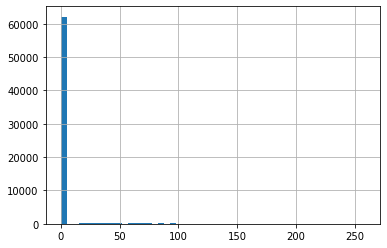

In [16]:
data_train['days_in_waiting_list'].hist(bins=50);

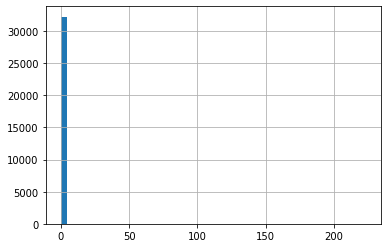

In [17]:
data_test['days_in_waiting_list'].hist(bins=50);

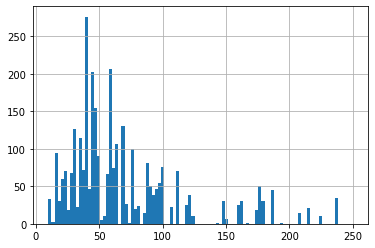

In [18]:
data_train['days_in_waiting_list'].hist(bins=100, range=(10, 250));

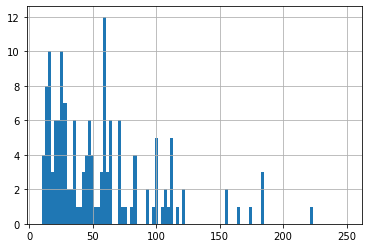

In [19]:
data_test['days_in_waiting_list'].hist(bins=100, range=(10, 250));

В стоблце 'days_in_waiting_list' аномальных значений не найдено.

In [20]:
data_train = data_train.query('adults > 0 & babies <= 1 & previous_bookings_not_canceled <= 6')
data_test = data_test.query('adults > 0')

Аномальные значения были удалены в столбцах 'adults', 'babies', 'previous_cancellations'. 

#### Проверка строковых значений

In [21]:
column_unique = ['arrival_date_month', 'meal', 'country', 'distribution_channel',
                'reserved_room_type', 'customer_type']
def func_unique(data, column_unique=column_unique):
    for column in column_unique:
        print(data[column].unique())

Найдем уникальные значения строковых значений всех категориальных столбцов.

In [22]:
func_unique(data_train)
func_unique(data_test)

['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB'

In [23]:
def strip_func(data):
    data['meal'] = data['meal'].str.strip()
    data['reserved_room_type'] = data['reserved_room_type'].str.strip()

In [24]:
strip_func(data_train)
strip_func(data_test)

В строковых значениях были удалены лишние пробелы.

#### Создание новых столбцов

Создадим новые столбцы с категориями стран (по частоте возникноваения), сезонов года в зависимости от месяца, бинарные категории (к примеру, есть дети - нет детей) для стоблцов 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'.

In [25]:
def categorize_country(country, data_group):
    try:
        if data_group[country] > 10000:
            return '> 10000'
        elif (data_group[country] > 1000) & (data_group[country] <= 10000):
            return '< 10000'
        elif data_group[country] <= 1000:
            return '< 1000'
    except:
        pass

In [26]:
data_train['categorize_country'] = data_train['country'].apply(categorize_country, 
                                                               data_group = data_train.groupby('country')['country'].count()) 
data_train = data_train.drop('country', axis=1)
data_test['categorize_country'] = data_test['country'].apply(categorize_country, 
                                                               data_group = data_test.groupby('country')['country'].count()) 
data_test = data_test.drop('country', axis=1)

In [27]:
def categorize_month(arrival_date_month):
    try:
        if (arrival_date_month == 'June') | (arrival_date_month == 'July') | (arrival_date_month == 'August'):
            return 'summer'
        elif (arrival_date_month == 'September') | (arrival_date_month == 'October') | (arrival_date_month == 'November'):
            return 'autumn'
        elif (arrival_date_month == 'December') | (arrival_date_month == 'January') | (arrival_date_month == 'February'):
            return 'winter'
        elif (arrival_date_month == 'March') | (arrival_date_month == 'April') | (arrival_date_month == 'May'):
            return 'spring'
    except:
        pass

In [28]:
data_train['categorize_arrival_date_month'] = data_train['arrival_date_month'].apply(categorize_month) 
data_train = data_train.drop('arrival_date_month', axis=1)
data_test['categorize_arrival_date_month'] = data_test['arrival_date_month'].apply(categorize_month) 
data_test = data_test.drop('arrival_date_month', axis=1)

In [29]:
def categorize_sign(sign, name):
    try:
        if sign == 0:
            return name + ' = 0'
        elif sign > 0:
            return name + ' > 0'
    except:
        pass

In [30]:
column_sign = ['children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
              'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces',
              'total_of_special_requests']

for c in column_sign:
    data_train['categorize_' + c] = data_train[c].apply(categorize_sign, name=c) 
    data_train = data_train.drop(c, axis=1)
    data_test['categorize_' + c] = data_test[c].apply(categorize_sign, name=c) 
    data_test = data_test.drop(c, axis=1)

#### Корреляционный анализ

In [31]:
data_train.corr()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,total_nights
id,1.000000,-0.241345,0.005517,0.248983,0.070519,0.008871,-0.094751,-0.157646,0.008406,-0.004195,-0.169430
is_canceled,-0.241345,1.000000,0.327383,-0.029613,0.012137,-0.001651,-0.014759,0.009251,0.040832,-0.029221,-0.000035
lead_time,0.005517,0.327383,1.000000,-0.021832,0.090563,-0.010676,0.045937,0.171279,0.117972,-0.077581,0.156090
arrival_date_year,0.248983,-0.029613,-0.021832,1.000000,-0.388575,0.009678,-0.005932,0.014968,0.037633,-0.017478,0.008757
arrival_date_week_number,0.070519,0.012137,0.090563,-0.388575,1.000000,0.047845,0.034189,0.031552,0.003812,-0.009481,0.041387
arrival_date_day_of_month,0.008871,-0.001651,-0.010676,0.009678,0.047845,1.000000,-0.002038,0.003654,0.008035,-0.012249,0.001849
stays_in_weekend_nights,-0.094751,-0.014759,0.045937,-0.005932,0.034189,-0.002038,1.000000,0.197328,0.119668,-0.079458,0.644861
stays_in_week_nights,-0.157646,0.009251,0.171279,0.014968,0.031552,0.003654,0.197328,1.000000,0.120929,-0.087717,0.876521
adults,0.008406,0.040832,0.117972,0.037633,0.003812,0.008035,0.119668,0.120929,1.000000,-0.138162,0.153039
is_repeated_guest,-0.004195,-0.029221,-0.077581,-0.017478,-0.009481,-0.012249,-0.079458,-0.087717,-0.138162,1.000000,-0.107402


In [32]:
data_test.corr()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,total_nights
id,1.000000,-0.459567,-0.047091,NaN,0.169976,0.017947,-0.064631,-0.117858,0.036596,-0.099464,-0.124939
is_canceled,-0.459567,1.000000,0.238382,NaN,0.037554,-0.008888,-0.002166,0.047081,0.079475,-0.125593,0.036173
lead_time,-0.047091,0.238382,1.000000,NaN,0.345030,0.033414,0.163537,0.290190,0.195624,-0.169299,0.309785
arrival_date_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,0.169976,0.037554,0.345030,NaN,1.000000,0.124324,0.064389,0.083315,0.121502,-0.062379,0.097500
arrival_date_day_of_month,0.017947,-0.008888,0.033414,NaN,0.124324,1.000000,0.002593,-0.029192,-0.019076,0.005329,-0.021814
stays_in_weekend_nights,-0.064631,-0.002166,0.163537,NaN,0.064389,0.002593,1.000000,0.171975,0.105608,-0.090122,0.626887
stays_in_week_nights,-0.117858,0.047081,0.290190,NaN,0.083315,-0.029192,0.171975,1.000000,0.147265,-0.114944,0.875311
adults,0.036596,0.079475,0.195624,NaN,0.121502,-0.019076,0.105608,0.147265,1.000000,-0.205743,0.168311
is_repeated_guest,-0.099464,-0.125593,-0.169299,NaN,-0.062379,0.005329,-0.090122,-0.114944,-0.205743,1.000000,-0.135147


Больше всего столбец is_canceled коррелирует с lead_time и is_repeated_guest.

Вывод:

Данные были выгружены, в датасете не было обнаружено пропусков, явных и неявных дубликатов. Аномальные значения были удалены в столбцах 'adults', 'babies', 'previous_cancellations'. В строковых значениях были удалены лишние пробелы. Были созданы новые столбцы с категориями стран (по частоте возникноваения), сезонов года в зависимости от месяца, бинарные категории (к примеру, есть дети - нет детей) для стоблцов 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'. Больше всего столбец is_canceled коррелирует с lead_time и is_repeated_guest.


Чаще всего отказываются от бронирования осенью, реже всего зимой. 

К концу месяца отказ от брони реже, в середине месяца выше.

Чаще всего отказываются те, кто не остается на выходные, а остается на два дня посреди недели.

Чаще всего откзаываются от бронирования двое взрослых, которые не имеют детей любого возраста.

Чаще от бронирования отказываются те, у кого включен завтрак, а тип забронированной комнаты - A.

Чаще отказываются те, у кого канал дистрибуции TA/TO, а тип заказа не связан ни с договором, ни с групповым заездом.

Чаще всего отказываются те, кто бронирует номер впервые.

Чаще всего отказываются те, кто не отменял заказ то этого.

Чаще всего отказываются при нулевом изменении параметров заказа и нулевым количеством специальных отметок.

Чаще всего отказываются при подтверждении заказа в день его оформления.

Чаще всего отказываются тех, кому не требуется парковочное место.

Отказываются от бронирования вне зависимости от дней между датой бронирования и датой прибытия. 

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента. На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Создадим стоблцы с сезонным коэффициентом, стоимостью номера и стоиммостью уборки.

In [33]:
def arrival_date_month_koef(arrival_date_month):
    try:
        if arrival_date_month == 'summer':
            return 1.4
        elif (arrival_date_month == 'autumn') | (arrival_date_month == 'spring'):
            return 1.2
        elif arrival_date_month == 'winter':
            return 1
    except:
        pass

In [34]:
data_train['arrival_date_month_koef'] = data_train['categorize_arrival_date_month'].apply(arrival_date_month_koef) 
data_test['arrival_date_month_koef'] = data_test['categorize_arrival_date_month'].apply(arrival_date_month_koef) 

In [35]:
def room_rate_func(reserved_room_type):
    try:
        if reserved_room_type == 'A':
            return 1000
        elif reserved_room_type == 'B':
            return 800
        elif reserved_room_type == 'C':
            return 600
        elif reserved_room_type == 'D':
            return 550
        elif reserved_room_type == 'E':
            return 500
        elif reserved_room_type == 'F':
            return 450
        elif reserved_room_type == 'G':
            return 350
    except:
        pass

In [36]:
data_train['room_rate'] = data_train['reserved_room_type'].apply(room_rate_func) 
data_test['room_rate'] = data_test['reserved_room_type'].apply(room_rate_func) 

In [37]:
def cleaning_rate_func(reserved_room_type):
    try:
        if reserved_room_type == 'A':
            return 400
        elif (reserved_room_type == 'B') | (reserved_room_type == 'C'):
            return 350
        elif ((reserved_room_type == 'D') | (reserved_room_type == 'E') |
             (reserved_room_type == 'F') | (reserved_room_type == 'G') ):
            return 150
    except:
        pass

In [38]:
data_train['cleaning_rate'] = data_train['reserved_room_type'].apply(cleaning_rate_func) 
data_test['cleaning_rate'] = data_test['reserved_room_type'].apply(cleaning_rate_func) 

Рассчитаем прибыль отеля до внедрения депозита.

In [39]:
def revenue_func(data):
    try:
        if (data['is_canceled'] == 0):
            if data['total_nights'] % 2 == 0:
                return (data['room_rate'] * data['arrival_date_month_koef'] * data['total_nights']
                           - data['cleaning_rate'] * (1 + data['total_nights'] / 2))
            else:
                return (data['room_rate'] * data['arrival_date_month_koef'] * data['total_nights']
                           - data['cleaning_rate'] * (1 + (data['total_nights'] - 1) / 2))
        elif (data['is_canceled'] == 1):
            return -1 * (data['room_rate'] * data['arrival_date_month_koef'] + data['cleaning_rate'])          
    except:
        pass

In [40]:
data_train['revenue'] = data_train.apply(revenue_func, axis=1)

In [41]:
data_test['revenue'] = data_test.apply(revenue_func, axis=1)
revenue_test_before = data_test['revenue'].sum()
revenue_test_before

32510590.0

Вывод:

Была оценена прибыль отеля без депозита за тестовый период, она равняется 32.5 млн рублей.

### Шаг 4. Разработка модели ML

#### Подготовка данных для обучения

Преобразуем категориальные признаки в численные методом горячего кодирования.

In [42]:
columns_ohe = ['meal', 'distribution_channel', 'reserved_room_type', 'customer_type',
            'categorize_arrival_date_month', 'categorize_children', 'categorize_total_of_special_requests',
               'categorize_babies', 'categorize_previous_bookings_not_canceled', 'categorize_country',
               'categorize_booking_changes', 'categorize_days_in_waiting_list', 'categorize_previous_cancellations',
               'categorize_required_car_parking_spaces']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
ohe.fit(data_train[columns_ohe])
def get_ohe(df, columns_ohe=columns_ohe):
    temp_df = pd.DataFrame(data=ohe.transform(df[columns_ohe]), columns=ohe.get_feature_names_out())
    df.drop(columns=columns_ohe, axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df   

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [43]:
pd.options.mode.chained_assignment = None

In [44]:
data_train_ohe = get_ohe(data_train)
data_test_ohe = get_ohe(data_test)

Разделим трейн и тест на признаки для обучения и целевые признаки.

In [45]:
features_train = data_train_ohe.drop(['is_canceled', 'id', 'arrival_date_month_koef', 
                                      'room_rate', 'cleaning_rate', 'revenue', 'arrival_date_year'], axis=1) 
features_test = data_test_ohe.drop(['is_canceled', 'id', 'arrival_date_month_koef', 
                                    'room_rate', 'cleaning_rate', 'revenue', 'arrival_date_year'], axis=1) 
target_train = data_train_ohe['is_canceled']
target_test = data_test_ohe['is_canceled']

Проведем масштабирование данных.

In [46]:
numeric = ['stays_in_weekend_nights', 'stays_in_week_nights', 'arrival_date_week_number', 
           'adults', 'total_nights', 'lead_time', 'arrival_date_day_of_month']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Исследуем баланс в целевом признаке.

In [47]:
(target_train == 1).sum()

23973

In [48]:
(target_train == 0).sum()

40834

Наблюдаем дисбаланс данных, нулевые значения встречаются в два раза чаще чем единичные, в дальнейшем придется балансировать данные путем увеличения выборки.

Вывод:

Категориальные признаки были преобразованы в численные техникой горячего кодирования. Данные также были отмасштабированы и разделены на целевой признак и признаки для обучения модели. Была исследована сбалансированность данных: наблюдается дисбаланас данных с преобладанием нулевых значений.

#### Изучение смещения данных

In [49]:
data_test_ohe['is_train'] = 0
data_train_ohe['is_train'] = 1

data_combine = pd.concat([data_train_ohe, data_test_ohe], axis=0, ignore_index=True)
data_combine = data_combine.drop(['is_canceled', 'id', 'arrival_date_month_koef', 
                                'room_rate', 'cleaning_rate', 'revenue', 'arrival_date_year'], axis=1)

y = data_combine['is_train'].values 
x = data_combine.drop(['is_train'], axis=1).values 

tst, trn = data_test.values, data_train.values

rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape) 

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 
    rfc.fit(X_train, y_train)
    probs = rfc.predict_proba(X_test)[:, 1] 
    predictions[test_idx] = probs
print('ROC-AUC:', roc_auc_score(y_true=y, y_score=predictions))

ROC-AUC: 0.8994708537879051


Вывод:

Столкнулась с проблемой: на трейне качество модели лучше чем на тесте. Когда искала варианты решения этой проблемы, прочитала про смещение данных. Обучила общий датасет смердженных датасетов трейна и теста, где целевой признак был флаг - трейн или тест. Если классификатор хорошо разделяет объекты на обучающий и тестовый датасет, то значение метрики ROC AUC должно быть значительно больше 0.5, в идеале близко к 1. Такая картина свидетельствует о сильном ковариантном сдвиге в данных. У меня ROC AUC получился почти 0.9, что свидетельствует о смещении данных.

#### Разработка модели

Найдем наилучшие параметры для дерева решений с учетом несбалансированности выборки.

In [50]:
%%time
imba_pipeline_dtc = make_pipeline(SMOTE(random_state=42),  DecisionTreeClassifier(random_state=13))
params = {
    'max_features': [2, 5, 8],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]}
new_params = {'decisiontreeclassifier__' + key: params[key] for key in params}
grid_imba_dtc = GridSearchCV(imba_pipeline_dtc, param_grid=new_params, cv=3, scoring='precision', return_train_score=True)
grid_imba_dtc.fit(features_train, target_train)

CPU times: user 1min 2s, sys: 247 ms, total: 1min 2s
Wall time: 1min 3s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=13))]),
             param_grid={'decisiontreeclassifier__max_depth': [4, 6, 10, 12],
                         'decisiontreeclassifier__max_features': [2, 5, 8],
                         'decisiontreeclassifier__random_state': [13]},
             return_train_score=True, scoring='precision')

In [51]:
grid_imba_dtc.best_params_

{'decisiontreeclassifier__max_depth': 4,
 'decisiontreeclassifier__max_features': 5,
 'decisiontreeclassifier__random_state': 13}

In [52]:
grid_imba_dtc.best_score_

0.6603375153950966

Найдем наилучшие параметры для случайного леса с учетом несбалансированности выборки.

In [53]:
%%time
imba_pipeline_rfc = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(random_state=13))
params = {
    'n_estimators': [30, 80, 150],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba_rfc = GridSearchCV(imba_pipeline_rfc, param_grid=new_params, cv=3, scoring='precision', return_train_score=True)
grid_imba_rfc.fit(features_train, target_train)

CPU times: user 2min 45s, sys: 581 ms, total: 2min 45s
Wall time: 2min 46s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 10, 12],
                         'randomforestclassifier__n_estimators': [30, 80, 150],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='precision')

In [54]:
best_param = grid_imba_rfc.best_params_
best_param

{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__n_estimators': 30,
 'randomforestclassifier__random_state': 13}

In [55]:
grid_imba_rfc.best_score_

0.6850635248149385

Обучим логистическую регрессию с учетом несбалансированности выборки.

In [56]:
imba_pipeline_log = make_pipeline(SMOTE(random_state=42), LogisticRegression(solver='liblinear', random_state=12345))
scores = cross_val_score(imba_pipeline_log, features_train, target_train, scoring='precision', cv=3)
final_score = np.mean(scores)
print(round(final_score,3))

0.59


Проверим наилучшую модель - случайный лес на тестовой выборке.

In [57]:
model_best = make_pipeline(SMOTE(random_state=42), RandomForestClassifier(random_state=12345, 
                                                                               max_depth=4,
                                                                               n_estimators=30,
                                                                               n_jobs=-1))
model_best.fit(features_train, target_train)
predictions_test = model_best.predict(features_test)
precision_test = precision_score(target_test, predictions_test)
print('precision = {0}'.format(round(precision_test,3)))

precision = 0.596


Вывод:

Была выбрана метрика precision. Это доля объектов, названными классификатором отказами от брони и при этом действительно являющимися отказами от брони.

- Для дерева решений наилучшая метрика precision была получена при максимальной глубине дерева равной 4, при максимальном числе признаков, по которым ищется лучшее разбиение в дереве, равному 5 и равняется 0.66.

- Для случайного леса наилучшая метрика precision была получена при максимальной глубине дерева равной 4, при количестве деревьев равному 30 и равняется 0.69. 

- Для логистической регрессии наилучшая метрика precision равняется 0.59.

Наилучшие показатели метрики у случайного леса. На тестовой выборки метрика precision равняется 0.6.

#### Расчет прибыли

In [58]:
data_test['pred_is_canceled'] = predictions_test
def revenue_with_deposit_func(data):
    try:
        room_cost = data['room_rate'] * data['arrival_date_month_koef'] * data['total_nights']
        room_cost_one_night = data['room_rate'] * data['arrival_date_month_koef'] + data['cleaning_rate']
        if (data['is_canceled'] == 0) :
            if data['total_nights'] % 2 == 0:
                return (room_cost - data['cleaning_rate'] * (1 + data['total_nights'] / 2))
            else:
                return (room_cost - data['cleaning_rate'] * (1 + (data['total_nights'] - 1) / 2))
        elif (data['is_canceled'] == 1) & (data['pred_is_canceled'] == 1):
            return -0.2 * room_cost_one_night
        elif (data['is_canceled'] == 1) & (data['pred_is_canceled'] == 0):
            return -1 * room_cost_one_night          
    except:
        pass

In [59]:
BUDGET = 400_000
data_test['revenue_with_deposit'] = data_test.apply(revenue_with_deposit_func, axis=1)
revenue_test_after = data_test['revenue_with_deposit'].sum()
revenue_ML = revenue_test_after - revenue_test_before - BUDGET
revenue_ML

800856.0

In [60]:
revenue_test_after 

33711446.0

Вывод:

Была оценена прибыль отеля прибыль отеля c депозитом за тестовый период, она равняется 33.7 млн рублей. Прибыль, которую принесет внедренение данной системы, равняется 800 тыс. рублей. 

### Шаг 5. Опишите портрет «ненадёжного» клиента

Анализ был проведен во 2 пункте.

Чаще всего отказываются от бронирования осенью, реже всего зимой. 

К концу месяца отказ от брони реже, в середине месяца выше.

Чаще всего отказываются те, кто не остается на выходные, а остается на два дня посреди недели.

Чаще всего откзаываются от бронирования двое взрослых, которые не имеют детей любого возраста.

Чаще от бронирования отказываются те, у кого включен завтрак, а тип забронированной комнаты - A.

Чаще отказываются те, у кого канал дистрибуции TA/TO, а тип заказа не связан ни с договором, ни с групповым заездом.

Чаще всего отказываются те, кто бронирует номер впервые.

Чаще всего отказываются те, кто не отменял заказ то этого.

Чаще всего отказываются при нулевом изменении параметров заказа и нулевым количеством специальных отметок.

Чаще всего отказываются при подтверждении заказа в день его оформления.

Чаще всего отказываются тех, кому не требуется парковочное место.

Отказываются от бронирования вне зависимости от дней между датой бронирования и датой прибытия. 

Оценим важность признаков.

In [61]:
def func_importance(model, data):
    feats = {}
    for feature, importance in zip(data.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,25)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature Importance', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances.head(10))

Наиболее важные признаки: страна, количество отменённых заказов у клиента, количество дней между датой бронирования и датой прибытия и количество специальных отметок.
Наименее важные признаки: тип забронированной комнаты и количество детей.

### Шаг 6. Напишите общий вывод

В данном проекте были сделаны следующие выводы:

Данные были выгружены, в датасете не было обнаружено пропусков, явных и неявных дубликатов. Аномальные значения были удалены в столбцах 'adults', 'babies', 'previous_cancellations'. В строковых значениях были удалены лишние пробелы. Были созданы новые столбцы с категориями стран (по частоте возникноваения), сезонов года в зависимости от месяца, бинарные категории (к примеру, есть дети - нет детей) для стоблцов 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'. Больше всего столбец is_canceled коррелирует с lead_time и is_repeated_guest.

Исследовательский анализ показал: 

  - Чаще всего отказываются от бронирования осенью, реже всего зимой. 

  - К концу месяца отказ от брони реже, в середине месяца выше.

  - Чаще всего отказываются те, кто не остается на выходные, а остается на два дня посреди недели.

  - Чаще всего откзаываются от бронирования двое взрослых, которые не имеют детей любого возраста.

  - Чаще от бронирования отказываются те, у кого включен завтрак, а тип забронированной комнаты - A.

  - Чаще отказываются те, у кого канал дистрибуции TA/TO, а тип заказа не связан ни с договором, ни с групповым заездом.

  - Чаще всего отказываются те, кто бронирует номер впервые.

  - Чаще всего отказываются те, кто не отменял заказ то этого.

  - Чаще всего отказываются при нулевом изменении параметров заказа и нулевым количеством специальных отметок.

  - Чаще всего отказываются при подтверждении заказа в день его оформления.

  - Чаще всего отказываются тех, кому не требуется парковочное место.

  - Отказываются от бронирования вне зависимости от дней между датой бронирования и датой прибытия. 
  
Была оценена прибыль отеля без депозита за тестовый период, она равняется 32.5 млн рублей.

Категориальные признаки были преобразованы в численные техникой горячего кодирования. Данные также были отмасштабированы и разделены на целевой признак и признаки для обучения модели. Была исследована сбалансированность данных: наблюдается дисбаланас данных с преобладанием нулевых значений.

Столкнулась с проблемой: на трейне качество модели лучше чем на тесте. Когда искала варианты решения этой проблемы, прочитала про смещение данных. Обучила общий датасет смердженных датасетов трейна и теста, где целевой признак был флаг - трейн или тест. Если классификатор хорошо разделяет объекты на обучающий и тестовый датасет, то значение метрики ROC AUC должно быть значительно больше 0.5, в идеале близко к 1. Такая картина свидетельствует о сильном ковариантном сдвиге в данных. У меня ROC AUC получился почти 0.9, что свидетельствует о смещении данных.

Была выбрана метрика precision. Это доля объектов, названными классификатором отказами от брони и при этом действительно являющимися отказами от брони. Были получены следующие реузльтаты:

  - Для дерева решений наилучшая метрика precision была получена при максимальной глубине дерева равной 4, при максимальном числе признаков, по которым ищется лучшее разбиение в дереве, равному 5 и равняется 0.66.

  - Для случайного леса наилучшая метрика precision была получена при максимальной глубине дерева равной 4, при количестве деревьев равному 30 и равняется 0.69. 

  - Для логистической регрессии наилучшая метрика precision равняется 0.59.

  - Наилучшие показатели метрики у случайного леса. На тестовой выборки метрика precision равняется 0.6.
  
Была оценена прибыль отеля прибыль отеля c депозитом за тестовый период, она равняется 33.7 млн рублей. Прибыль, которую принесет внедренение данной системы, равняется 800 тыс. рублей. 

Наиболее важные признаки: страна, количество отменённых заказов у клиента, количество дней между датой бронирования и датой прибытия и количество специальных отметок. Наименее важные признаки: тип забронированной комнаты и количество детей.